In [ ]:
import cv2
import numpy as np
import os

from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
# Загрузка видео в Colab
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print("Загружено видео:", video_path)

Saving mona-lisa.avi to mona-lisa (7).avi
Загружено видео: mona-lisa (7).avi


### Получение первого кадра

Размер первого кадра: (360, 640, 3)


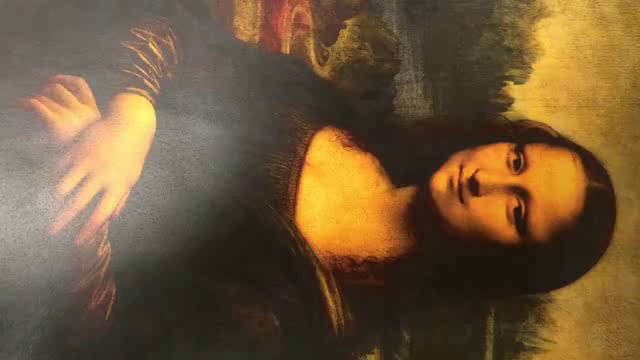

In [ ]:
def get_first_frame(video_path: str):
    """
    Считывает первый кадр из видео и возвращает его (BGR).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Не удалось открыть видео: {video_path}")

    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise RuntimeError("Не удалось прочитать первый кадр.")

    return frame

first_frame = get_first_frame(video_path)
print("Размер первого кадра:", first_frame.shape)
cv2_imshow(first_frame)


### Инициализация ключевых точек (goodFeaturesToTrack)

Начальное количество точек: 324


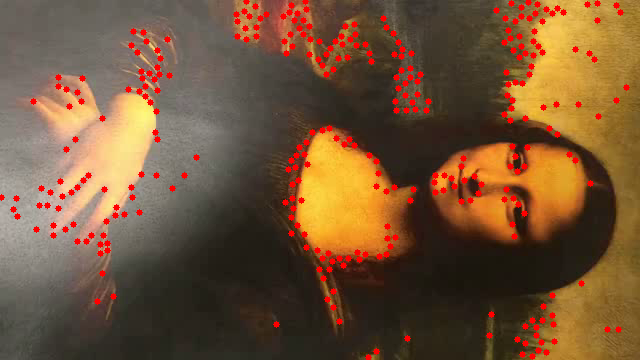

In [ ]:
# Параметры для поиска "хороших" точек (Shi-Tomasi corner detector)
feature_params = dict(
    maxCorners = 500,      # максимальное число точек
    qualityLevel = 0.05,   # минимальное качество
    minDistance = 7,       # минимальное расстояние между точками
    blockSize = 7
)

def detect_initial_points(frame_bgr, feature_params):
    """
    Находит ключевые точки на первом кадре.
    Возвращает массив точек p0 формы (N, 1, 2) типа float32.
    """
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)
    return gray, p0

prev_gray, p0 = detect_initial_points(first_frame, feature_params)
print("Начальное количество точек:", 0 if p0 is None else len(p0))

# Визуализируем найденные точки на первом кадре
vis = first_frame.copy()
if p0 is not None:
    for pt in p0:
        x, y = pt.ravel()
        cv2.circle(vis, (int(x), int(y)), 3, (0, 0, 255), -1)
cv2_imshow(vis)

### Параметры оптического потока (Lucas–Kanade)

In [ ]:
# Параметры Lucas–Kanade (пирамидальный оптический поток)
lk_params = dict(
    winSize  = (15, 15),      # окно поиска
    maxLevel = 2,             # число уровней пирамиды
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)


### Основная функция обработки видео с оптическим потоком

In [ ]:
def process_video_optical_flow(
    video_path,
    output_path,
    feature_params,
    lk_params,
    reinit_min_points=30,   # если точек меньше этого числа, заново ищем их в текущем кадре
    min_points_for_box=10   # минимум точек, чтобы рисовать рамку
):
    """
    Трекинг объекта по оптическому потоку (Lucas–Kanade).
    1. На первом кадре ищем ключевые точки (goodFeaturesToTrack).
    2. На каждом следующем кадре считаем оптический поток (calcOpticalFlowPyrLK).
    3. Сдвигаем точки, рисуем их и по ним строим прямоугольную рамку вокруг объекта.
    4. Если точек стало мало, переинициализируем их на текущем кадре.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Не удалось открыть видео: {video_path}")

    # Получаем параметры исходного видео
    fps  = cap.get(cv2.CAP_PROP_FPS)
    w    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h    = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    # Считываем первый кадр
    ret, old_frame = cap.read()
    if not ret:
        cap.release()
        out.release()
        raise RuntimeError("Не удалось прочитать первый кадр при обработке видео.")

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    if p0 is None:
        print("Не удалось найти начальные ключевые точки.")
        cap.release()
        out.release()
        return

    frame_idx = 0
    success_frames = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Если слишком мало точек — переинициализируем на текущем кадре
        if p0 is None or len(p0) < reinit_min_points:
            p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
            old_gray = frame_gray.copy()
            # если опять не нашли — пропускаем рамку на этом кадре
            if p0 is None:
                out.write(frame)
                frame_idx += 1
                continue

        # Считаем оптический поток: новые позиции точек p1
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # st == 1 — успешные соответствия
        if p1 is None or st is None:
            out.write(frame)
            frame_idx += 1
            continue

        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Если после фильтрации точек мало — не рисуем рамку
        if len(good_new) >= min_points_for_box:
            success_frames += 1

            # Рисуем точки
            vis = frame.copy()
            pts = good_new  # (N, 2)

            for x, y in pts:
                cv2.circle(vis, (int(x), int(y)), 3, (0, 0, 255), -1)

            # Преобразуем точки к форме (N, 1, 2) и int32
            pts_int = pts.reshape(-1, 1, 2).astype(np.int32)

            # Находим минимальный по площади вращающийся прямоугольник
            rect = cv2.minAreaRect(pts_int)
            box = cv2.boxPoints(rect)   # 4 угла прямоугольника (float32)
            box = np.int32(box)

            # Рисуем повёрнутый прямоугольник
            cv2.polylines(vis, [box], isClosed=True, color=(0, 255, 0), thickness=2)

            # Подпись возле одного из углов
            x_text, y_text = box[0]
            cv2.putText(
                vis,
                "Mona Liza",
                (int(x_text), int(y_text) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA
            )

            out.write(vis)
        else:
            # Точек мало — просто записываем кадр как есть
            out.write(frame)

        # Обновляем "старые" кадр и точки для следующей итерации
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        frame_idx += 1
        if frame_idx % 30 == 0:
            print(f"Кадр {frame_idx}, кадров с рамкой: {success_frames}")

    cap.release()
    out.release()
    print("Готово.")
    print(f"Всего кадров: {frame_idx}, кадров с рамкой: {success_frames}")


### Запуск трекинга и скачивание результата

In [ ]:
output_video_path = "tracked_" + os.path.basename(video_path)

process_video_optical_flow(
    video_path=video_path,
    output_path=output_video_path,
    feature_params=feature_params,
    lk_params=lk_params,
    reinit_min_points=30,
    min_points_for_box=10
)

files.download(output_video_path)


Кадр 30, кадров с рамкой: 30
Кадр 60, кадров с рамкой: 60
Кадр 90, кадров с рамкой: 90
Кадр 120, кадров с рамкой: 120
Кадр 150, кадров с рамкой: 150
Кадр 180, кадров с рамкой: 180
Кадр 210, кадров с рамкой: 210
Кадр 240, кадров с рамкой: 240
Кадр 270, кадров с рамкой: 270
Кадр 300, кадров с рамкой: 300
Кадр 330, кадров с рамкой: 330
Кадр 360, кадров с рамкой: 360
Кадр 390, кадров с рамкой: 390
Кадр 420, кадров с рамкой: 420
Кадр 450, кадров с рамкой: 450
Кадр 480, кадров с рамкой: 480
Кадр 510, кадров с рамкой: 510
Кадр 540, кадров с рамкой: 540
Готово.
Всего кадров: 557, кадров с рамкой: 557


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt  # не забудь импортировать один раз в ноутбуке

def process_video_optical_flow(
    video_path,
    output_path,
    feature_params,
    lk_params,
    reinit_min_points=30,   # если точек меньше этого числа, заново ищем их на текущем кадре
    min_points_for_box=10   # минимум точек, чтобы рисовать рамку
):
    """
    Трекинг объекта по оптическому потоку (Lucas–Kanade).
    Параллельно собирает статистику:
    - время каждого кадра (в секундах),
    - количество ключевых точек на кадре.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Не удалось открыть видео: {video_path}")

    # Параметры исходного видео
    fps  = cap.get(cv2.CAP_PROP_FPS)
    w    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h    = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    # Считываем первый кадр
    ret, old_frame = cap.read()
    if not ret:
        cap.release()
        out.release()
        raise RuntimeError("Не удалось прочитать первый кадр при обработке видео.")

    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    if p0 is None:
        print("Не удалось найти начальные ключевые точки.")
        cap.release()
        out.release()
        return [], []

    frame_idx = 0
    success_frames = 0

    # --- списки для графика ---
    frame_times = []              # время кадра в секундах
    num_keypoints_per_frame = []  # количество ключевых точек на кадре

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Для этого кадра будем считать количество точек (по умолчанию 0)
        num_kp = 0

        # Если слишком мало точек — переинициализируем на текущем кадре
        if p0 is None or len(p0) < reinit_min_points:
            p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
            old_gray = frame_gray.copy()
            # если опять не нашли — пропускаем рамку на этом кадре
            if p0 is None:
                out.write(frame)
                # логируем: 0 точек
                frame_times.append(frame_idx / fps)
                num_keypoints_per_frame.append(0)
                frame_idx += 1
                continue

        # Считаем оптический поток: новые позиции точек p1
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # st == 1 — успешные соответствия
        if p1 is None or st is None:
            out.write(frame)
            frame_times.append(frame_idx / fps)
            num_keypoints_per_frame.append(0)
            frame_idx += 1
            continue

        good_new = p1[st == 1]
        good_old = p0[st == 1]

        num_kp = len(good_new)  # сколько хороших точек на этом кадре

        # Если после фильтрации точек мало — не рисуем рамку (но логируем кол-во)
        if len(good_new) >= min_points_for_box:
            success_frames += 1

            # Рисуем точки
            vis = frame.copy()
            pts = good_new  # (N, 2)

            for x, y in pts:
                cv2.circle(vis, (int(x), int(y)), 3, (0, 0, 255), -1)

            # Преобразуем точки к форме (N, 1, 2) и int32
            pts_int = pts.reshape(-1, 1, 2).astype(np.int32)

            # Находим минимальный по площади вращающийся прямоугольник
            rect = cv2.minAreaRect(pts_int)
            box = cv2.boxPoints(rect)   # 4 угла прямоугольника (float32)
            box = np.int32(box)

            # Рисуем повёрнутый прямоугольник
            cv2.polylines(vis, [box], isClosed=True, color=(0, 255, 0), thickness=2)

            # Подпись возле одного из углов
            x_text, y_text = box[0]
            cv2.putText(
                vis,
                "Mona Liza",
                (int(x_text), int(y_text) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA
            )

            out.write(vis)
        else:
            # Точек мало — просто записываем кадр как есть
            out.write(frame)

        # Логируем время и количество точек
        frame_times.append(frame_idx / fps)
        num_keypoints_per_frame.append(num_kp)

        # Обновляем "старые" кадр и точки для следующей итерации
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        frame_idx += 1
        if frame_idx % 30 == 0:
            print(f"Кадр {frame_idx}, кадров с рамкой: {success_frames}")

    cap.release()
    out.release()
    print("Готово.")
    print(f"Всего кадров: {frame_idx}, кадров с рамкой: {success_frames}")

    return frame_times, num_keypoints_per_frame


In [ ]:
output_video_path = "tracked_flow_" + os.path.basename(video_path)

times, kp_counts = process_video_optical_flow(
    video_path=video_path,
    output_path=output_video_path,
    feature_params=feature_params,
    lk_params=lk_params,
    reinit_min_points=30,
    min_points_for_box=10
)

files.download(output_video_path)

Кадр 30, кадров с рамкой: 30
Кадр 60, кадров с рамкой: 60
Кадр 90, кадров с рамкой: 90
Кадр 120, кадров с рамкой: 120
Кадр 150, кадров с рамкой: 150
Кадр 180, кадров с рамкой: 180
Кадр 210, кадров с рамкой: 210
Кадр 240, кадров с рамкой: 240
Кадр 270, кадров с рамкой: 270
Кадр 300, кадров с рамкой: 300
Кадр 330, кадров с рамкой: 330
Кадр 360, кадров с рамкой: 360
Кадр 390, кадров с рамкой: 390
Кадр 420, кадров с рамкой: 420
Кадр 450, кадров с рамкой: 450
Кадр 480, кадров с рамкой: 480
Кадр 510, кадров с рамкой: 510
Кадр 540, кадров с рамкой: 540
Готово.
Всего кадров: 557, кадров с рамкой: 557


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

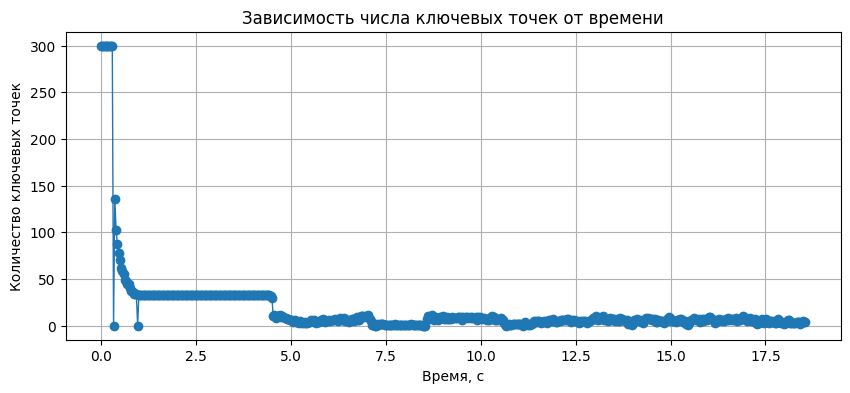

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(times, kp_counts, marker='o', linewidth=1)
plt.xlabel("Время, с")
plt.ylabel("Количество ключевых точек")
plt.title("Зависимость числа ключевых точек от времени")
plt.grid(True)
plt.show()